In [2]:
import nglview as nv
import copy
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from rdkit.Chem import rdBase
from rdkit.Chem import rdMolAlign
from rdkit.Chem import rdMolDescriptors
import numpy as np

In [3]:
print(rdBase.rdkitVersion)

2020.09.1


In [4]:
p = AllChem.ETKDGv2()
p.verbose = True

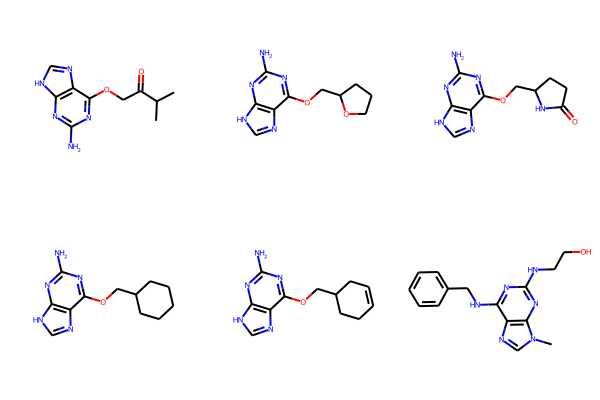

In [6]:
mols = [m for m in Chem.SDMolSupplier('./data/cdk2.sdf') if m != None][:6]
for mol in mols:
    mol.RemoveAllConformers()
hmols_1 = [Chem.AddHs(m) for m in mols]
hmols_2 = copy.deepcopy(hmols_1)
# Generate 100 conformers per each molecule
for mol in hmols_1:
    # AllChem.EmbedMolecule(mol, p, )
    AllChem.EmbedMultipleConfs(mol, 100, p)

for mol in hmols_2:
    # AllChem.EmbedMolecule(mol, p, )
    AllChem.EmbedMultipleConfs(mol, 100, p)
Draw.MolsToGridImage(mols)

To conduct GetCrippenO3A and GetO3A, I calculate crippen_contrib of each atom and MMFF params of molecules.

In [10]:
crippen_contribs = [rdMolDescriptors._CalcCrippenContribs(mol) for mol in hmols_1]
crippen_ref_contrib = crippen_contribs[0]
crippen_prob_contribs = crippen_contribs[1:]
ref_mol1 = hmols_1[0]
prob_mols_1 = hmols_1[1:]

mmff_params = [AllChem.MMFFGetMoleculeProperties(mol) for mol in hmols_2]
mmff_ref_param = mmff_params[0]
mmff_prob_params = mmff_params[1:]
ref_mol2 = hmols_2[0]
prob_mols_2 = hmols_2[1:]

print(ref_mol1.GetNumConformers())


100


OK Let’s align molecules and visualize them!
I retrieved the best score index from multi conformers of each molecule and added viewer.
For crippenO3A…

In [15]:
view = nv.NGLWidget()
component = view.add_component(ref_mol1)
component.clear()
crippen_score = []
for idx, mol in enumerate(prob_mols_1):
    tempscore = []
    for cid in range(100):
        crippenO3A = rdMolAlign.GetCrippenO3A(mol, ref_mol1, crippen_prob_contribs[idx], crippen_ref_contrib, cid, 0)
        crippenO3A.Align()
        tempscore.append(crippenO3A.Score())
    best = np.argmax(tempscore)
    mol_string = Chem.MolToMolBlock(mol, confId=int(best))
    temp_mol = Chem.MolFromMolBlock(mol_string, removeHs=False)
    component = view.add_component(temp_mol)
    component.clear()
    component.add_ball_and_stick(multipleBond=True)
    crippen_score.append(tempscore[best])
view

NGLWidget()

In [13]:
print(crippen_score)

[103.20263478517323, 103.31946610467878, 102.27785317205816, 102.52523174671295, 92.88603136836556]


For O3A…

In [16]:
view = nv.NGLWidget()
component = view.add_component(ref_mol2)
component.clear()

pyO3A_score = []
for idx, mol in enumerate(prob_mols_2):
    tempscore = []
    for cid in range(100):
        pyO3A = rdMolAlign.GetO3A(mol, ref_mol2, mmff_prob_params[idx], mmff_ref_param, cid, 0)
        pyO3A.Align()
        tempscore.append(pyO3A.Score())
    best = np.argmax(tempscore)
    mol_string = Chem.MolToMolBlock(mol, confId=int(best))
    temp_mol = Chem.MolFromMolBlock(mol_string, removeHs=False)
    component = view.add_component(temp_mol)
    component.clear()
    component.add_ball_and_stick(multipleBond=True)
    pyO3A_score.append(tempscore[best])

view

NGLWidget()

In [17]:
print(pyO3A_score)

[147.02873886166984, 147.09072757640484, 143.82657484538376, 144.70581677501013, 131.4763160269165]
